In [1]:
#Custom TypeSelector class to separate categorical and numerical columns


import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 
import matplotlib
%matplotlib inline

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
        self.column_names = []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        self.column_names = X.select_dtypes(include=[self.dtype]).columns.tolist()
        return X.select_dtypes(include=[self.dtype])   
    
    def get_feature_names(self):
        return self.column_names
    

    

In [2]:
traindata = pd.read_csv("./traincleaned.csv")

#traindata.dtypes
#dtypes are object, int64, and float64

#ts = TypeSelector(np.number)
#ts.fit_transform(traindata)

#separate the house price from the other data

X = traindata.drop(['SalePrice', 'Id'], axis = 1)
#You can covert the target variable to numpy 
y = traindata['SalePrice'].values 

#convert SalePrice using log transform
#y = np.log(y)





In [3]:
#steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', TypeSelector("object") ), 
                                          ('imputer', SimpleImputer(strategy="most_frequent")),
                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False, handle_unknown = 'ignore' ) ) ] )
    
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', TypeSelector(np.number) ),
                                  ('imputer', SimpleImputer(strategy = 'median') ),
                                   ( 'std_scaler', StandardScaler() )      
                                   ] )

#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
preprocess_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

In [15]:
X_transformed = preprocess_pipeline.fit_transform(X)
ohe = categorical_pipeline.named_steps['one_hot_encoder']
print(ohe.get_feature_names())

imput = numerical_pipeline.named_steps['num_selector']
print(imput.get_feature_names())

ohe.get_feature_names().shape
len(imput.get_feature_names())

['x0_SC120' 'x0_SC160' 'x0_SC180' 'x0_SC190' 'x0_SC20' 'x0_SC30' 'x0_SC40'
 'x0_SC45' 'x0_SC50' 'x0_SC60' 'x0_SC70' 'x0_SC75' 'x0_SC80' 'x0_SC85'
 'x0_SC90' 'x1_C (all)' 'x1_FV' 'x1_RH' 'x1_RL' 'x1_RM' 'x2_1' 'x2_2'
 'x2_None' 'x3_Bnk' 'x3_HLS' 'x3_Low' 'x3_Lvl' 'x4_Corner' 'x4_CulDSac'
 'x4_FR2' 'x4_FR3' 'x4_Inside' 'x5_Blmngtn' 'x5_Blueste' 'x5_BrDale'
 'x5_BrkSide' 'x5_ClearCr' 'x5_CollgCr' 'x5_Crawfor' 'x5_Edwards'
 'x5_Gilbert' 'x5_IDOTRR' 'x5_MeadowV' 'x5_Mitchel' 'x5_NAmes'
 'x5_NPkVill' 'x5_NWAmes' 'x5_NoRidge' 'x5_NridgHt' 'x5_OldTown'
 'x5_SWISU' 'x5_Sawyer' 'x5_SawyerW' 'x5_Somerst' 'x5_StoneBr' 'x5_Timber'
 'x5_Veenker' 'x6_Artery' 'x6_Feedr' 'x6_Norm' 'x6_PosA' 'x6_PosN'
 'x6_RRAe' 'x6_RRAn' 'x6_RRNe' 'x6_RRNn' 'x7_Artery' 'x7_Feedr' 'x7_Norm'
 'x7_PosA' 'x7_PosN' 'x7_RRAe' 'x7_RRAn' 'x7_RRNn' 'x8_1Fam' 'x8_2fmCon'
 'x8_Duplex' 'x8_Twnhs' 'x8_TwnhsE' 'x9_1.5Fin' 'x9_1.5Unf' 'x9_1Story'
 'x9_2.5Fin' 'x9_2.5Unf' 'x9_2Story' 'x9_SFoyer' 'x9_SLvl' 'x10_Flat'
 'x10_Gable' 'x10_

52

In [48]:
print(X_transformed.shape)
print(X_transformed)

(1456, 260)
[[   0.    0.    0. ...    0.    0. 2008.]
 [   0.    0.    0. ...    0.    0. 2007.]
 [   0.    0.    0. ...    0.    0. 2008.]
 ...
 [   0.    0.    0. ...    0. 2500. 2010.]
 [   0.    0.    0. ...    0.    0. 2010.]
 [   0.    0.    0. ...    0.    0. 2008.]]


In [4]:
#train test split

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, shuffle = True,random_state = 1) 
                                                    


print('train set:', x_train.shape)
print('test set:', y_train.shape)
print('train set:', x_test.shape)
print('test set:', y_test.shape)




train set: (1164, 79)
test set: (1164,)
train set: (292, 79)
test set: (292,)


# Lasso Reg model

In [5]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

scorer = make_scorer(mean_squared_error, greater_is_better=False)

lasso_reg = Lasso()

prepare_predict_pipeline = Pipeline([
    ('prepare', preprocess_pipeline),
    ('predict', lasso_reg),
])

params = [
    {
        'predict__alpha':[10, 1, 0.1, 0.001,0.0005]
    }
]

grid_search = GridSearchCV(prepare_predict_pipeline, param_grid=params, scoring=scorer, cv = 5, verbose=1)
grid_search.fit(x_train, np.log(y_train))






Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('prepare',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('categorical_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('cat_selector',
                                                                                         TypeSelector(dtype='object')),
                                                                                        ('imputer',
                                                                                         SimpleImputer(add_indicator=False,
                                                                                                       copy=True,
                                 

# Lasso Reg results

In [6]:
cvres = grid_search.cv_results_
cvres

[(np.sqrt(-score), stddev, para) for score, stddev, para in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres['params'])]

[(0.39119473548888123, 0.009399451824531892, {'predict__alpha': 10}),
 (0.39119473548888123, 0.009399451824531892, {'predict__alpha': 1}),
 (0.20678823383040826, 0.005245886275674108, {'predict__alpha': 0.1}),
 (0.11226393524253434, 0.003082974400011466, {'predict__alpha': 0.001}),
 (0.11119299787412419, 0.0026642745010787157, {'predict__alpha': 0.0005})]

In [17]:
categorical_names = grid_search.best_estimator_.named_steps['prepare'].get_params()['categorical_pipeline'].named_steps['one_hot_encoder'].get_feature_names()
numerical_names = np.array(grid_search.best_estimator_.named_steps['prepare'].get_params()['numerical_pipeline'].named_steps['num_selector'].get_feature_names())
feature_names = np.concatenate((categorical_names, numerical_names))
pred = grid_search.best_estimator_.predict(x_test)
print('result on test set:' ,np.sqrt(mean_squared_error(np.log(y_test), pred)))

result on test set: 0.11640163502901037


In [9]:


coef = pd.Series(grid_search.best_estimator_.named_steps['predict'].coef_, index = feature_names)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 106 variables and eliminated the other 151 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

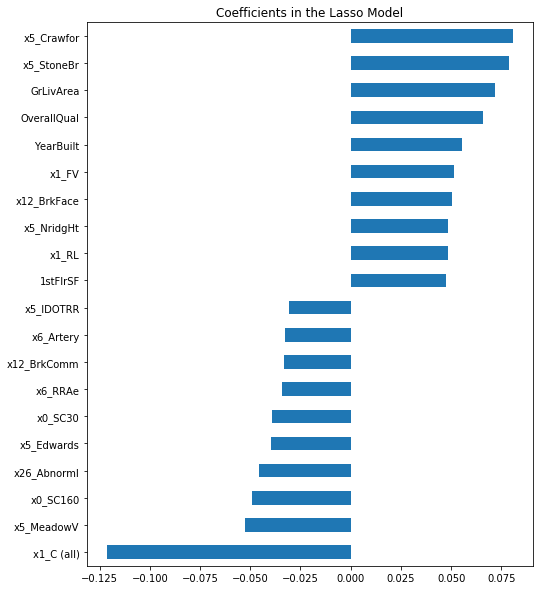

In [21]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


# Ridge regression

In [23]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge()

prepare_predict_pipeline = Pipeline([
    ('prepare', preprocess_pipeline),
    ('predict', ridge_reg),
])

params = [
    {
        'predict__alpha':[10, 1, 0.1, 0.001,0.0005]
    }
]

grid_search = GridSearchCV(prepare_predict_pipeline, param_grid=params, scoring=scorer, cv = 5, verbose=1)
grid_search.fit(x_train, np.log(y_train))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('prepare',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('categorical_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('cat_selector',
                                                                                         TypeSelector(dtype='object')),
                                                                                        ('imputer',
                                                                                         SimpleImputer(add_indicator=False,
                                                                                                       copy=True,
                                 

In [26]:
cvres = grid_search.cv_results_
cvres

[(np.sqrt(-score), stddev, para) for score, stddev, para in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres['params'])]

[(0.11470985567245902, 0.002719336495523738, {'predict__alpha': 10}),
 (0.11728501185138117, 0.002384602364893191, {'predict__alpha': 1}),
 (0.12241696807533343, 0.0023201803068206993, {'predict__alpha': 0.1}),
 (0.1252099137105652, 0.002165470256557537, {'predict__alpha': 0.001}),
 (0.1252706341534694, 0.002160596416739806, {'predict__alpha': 0.0005})]

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

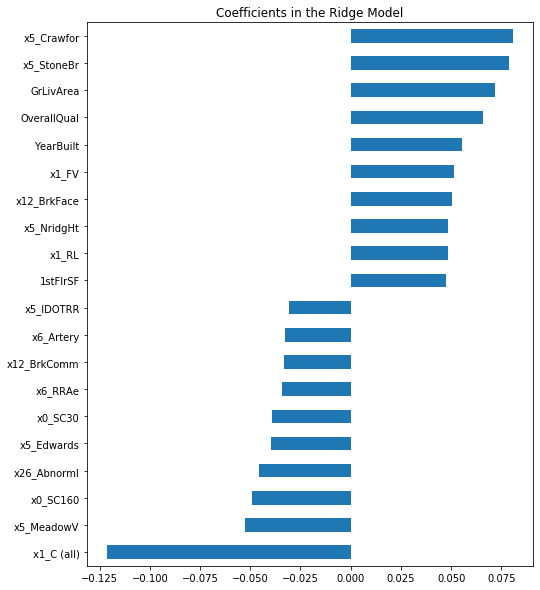

In [27]:


coef = pd.Series(grid_search.best_estimator_.named_steps['predict'].coef_, index = feature_names)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [28]:
pred = grid_search.best_estimator_.predict(x_test)
print('result on test set:' ,np.sqrt(mean_squared_error(np.log(y_test), pred)))

result on test set: 0.11888848516610939


# Elastic net

In [7]:
from sklearn.linear_model import ElasticNet

elasticnet_reg = ElasticNet()

prepare_predict_pipeline = Pipeline([
    ('prepare', preprocess_pipeline),
    ('predict', elasticnet_reg),
])

params = [
    {
        'predict__alpha': [10, 1, 0.1, 0.001,0.0005],
              'predict__l1_ratio': np.arange(0.1,1.0,0.1),
              'predict__max_iter':[100000]
    }
]

grid_search = GridSearchCV(prepare_predict_pipeline, param_grid=params, scoring=scorer, cv = 5, verbose=1)
grid_search.fit(x_train, np.log(y_train))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   34.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('prepare',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('categorical_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('cat_selector',
                                                                                         TypeSelector(dtype='object')),
                                                                                        ('imputer',
                                                                                         SimpleImputer(add_indicator=False,
                                                                                                       copy=True,
                                 

In [15]:
cvres = grid_search.cv_results_
grid_search.best_estimator_

#[(np.sqrt(-score), stddev, para) for score, stddev, para in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres['params'])]

Pipeline(memory=None,
         steps=[('prepare',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  TypeSelector(dtype='object')),
                                                                 ('imputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                strategy='most_frequent',
            

Text(0.5, 1.0, 'Coefficients in the ElasticNet Model')

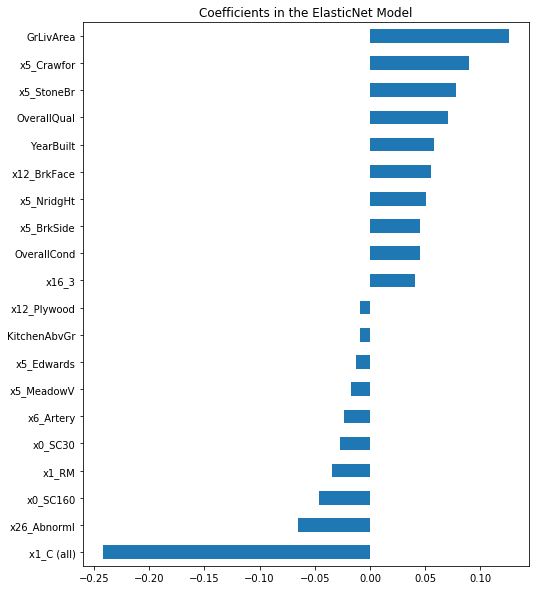

In [31]:
coef = pd.Series(grid_search.best_estimator_.named_steps['predict'].coef_, index = feature_names)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")

In [32]:
pred = grid_search.best_estimator_.predict(x_test)
print('result on test set:' ,np.sqrt(mean_squared_error(np.log(y_test), pred)))

result on test set: 0.11500966968807852


# Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor

randomforestreg = RandomForestRegressor()

prepare_predict_pipeline = Pipeline([
    ('prepare', preprocess_pipeline),
    ('predict', randomforestreg),
])

params = {'predict__n_estimators':[100,150,200],
              'predict__max_features':[25,50,75],
              'predict__min_samples_split':[2,4,6]}

grid_search = GridSearchCV(prepare_predict_pipeline, param_grid=params, scoring=scorer, cv = 5, verbose=1)
grid_search.fit(x_train, np.log(y_train))


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('prepare',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('categorical_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('cat_selector',
                                                                                         TypeSelector(dtype='object')),
                                                                                        ('imputer',
                                                                                         SimpleImputer(add_indicator=False,
                                                                                                       copy=True,
                                 

In [17]:
cvres = grid_search.cv_results_
#cvres
grid_search.best_estimator_
#[(np.sqrt(-score), stddev, para) for score, stddev, para in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres['params'])]

Pipeline(memory=None,
         steps=[('prepare',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  TypeSelector(dtype='object')),
                                                                 ('imputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                strategy='most_frequent',
            

In [35]:
pred = grid_search.best_estimator_.predict(x_test)
print('result on test set:' ,np.sqrt(mean_squared_error(np.log(y_test), pred)))

result on test set: 0.13403980320159567


# XGBoost

In [19]:
from xgboost import XGBRegressor


xgboostreg = XGBRegressor()

prepare_predict_pipeline = Pipeline([
    ('prepare', preprocess_pipeline),
    ('predict', xgboostreg),
])

params = {'predict__n_estimators':[100,200,300,400,500],
              'predict__max_depth':[1,2,3],
             }

grid_search = GridSearchCV(prepare_predict_pipeline, param_grid=params, scoring=scorer, cv = 5, verbose=1)
grid_search.fit(x_train, np.log(y_train))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[10:13:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[10:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[10:14:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:14:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:14:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.2min finished


[10:14:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('prepare',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('categorical_pipeline',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('cat_selector',
                                                                                         TypeSelector(dtype='object')),
                                                                                        ('imputer',
                                                                                         SimpleImputer(add_indicator=False,
                                                                                                       copy=True,
                                 

In [20]:
cvres = grid_search.cv_results_
cvres
grid_search.best_estimator_
#[(np.sqrt(-score), stddev, para) for score, stddev, para in zip(cvres['mean_test_score'], cvres['std_test_score'], cvres['params'])]

Pipeline(memory=None,
         steps=[('prepare',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  TypeSelector(dtype='object')),
                                                                 ('imputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                strategy='most_frequent',
            

In [38]:
pred = grid_search.best_estimator_.predict(x_test)
print('result on test set:' ,np.sqrt(mean_squared_error(np.log(y_test), pred)))

result on test set: 0.11232278834384246
